In [1]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

2024-04-19 14:28:19.760508: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
directory = r"/Users/rajeevkalose/Desktop/archive/Medical mask/Medical mask/Medical Mask/annotations"
image_directory = r"/Users/rajeevkalose/Desktop/archive/Medical mask/Medical mask/Medical Mask/images"

In [3]:
df = pd.read_csv(r"/Users/rajeevkalose/Desktop/archive/train.csv")
df_test = pd.read_csv(r"/Users/rajeevkalose/Desktop/archive/submission.csv")

In [4]:
df.head(10)

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask
5,6427.png,218,98,577,580,face_with_mask_incorrect
6,6427.png,278,386,582,582,mask_surgical
7,4591.png,239,9,522,342,face_with_mask
8,4591.png,255,159,491,341,mask_colorful
9,5392.jpg,261,0,444,257,face_other_covering


In [6]:
cvNet = cv2.dnn.readNetFromCaffe(prototxt=r"/Users/rajeevkalose/Desktop/archive/deploy.prototxt.txt",
                                            caffeModel=r"/Users/rajeevkalose/Desktop/archive/res10_300x300_ssd_iter_140000.caffemodel")
cvNet

< cv2.dnn.Net 0x7f8729072a30>

In [7]:
def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

In [8]:
jsonfiles= []
for i in os.listdir(directory):
    jsonfiles.append(getJSON(os.path.join(directory,i)))
jsonfiles[0]

{'FileName': '5045.jpg',
 'NumOfAnno': 4,
 'Annotations': [{'isProtected': False,
   'ID': 516598418402004352,
   'BoundingBox': [1737, 339, 2062, 740],
   'classname': 'face_with_mask',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 131128420050989904,
   'BoundingBox': [636, 207, 946, 634],
   'classname': 'face_with_mask',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 944789222496780416,
   'BoundingBox': [677, 399, 929, 620],
   'classname': 'mask_surgical',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 587553649932228096,
   'BoundingBox': [1812, 516, 2049, 722],
   'classname': 'mask_surgical',
   'Confidence': 1,
   'Attributes': {}}]}

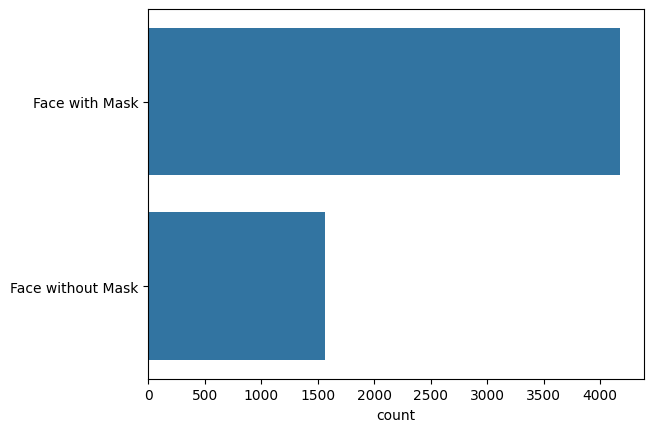

In [9]:
data = []
img_size = 124
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels = {'mask': 0, 'without mask': 1}

# Assuming you have defined the function getJSON
# Assuming you have defined the function shuffle

for i in df["name"].unique():
    f = i + ".json"
    for j in getJSON(os.path.join(directory, f)).get("Annotations"):
        if j["classname"] in mask:
            x, y, w, h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory, i), 1)
            img = img[y:h, x:w]
            img = cv2.resize(img, (img_size, img_size))
            data.append([img, labels["mask"]])
        if j["classname"] in non_mask:
            x, y, w, h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory, i), 1)
            img = img[y:h, x:w]
            img = cv2.resize(img, (img_size, img_size))
            data.append([img, labels["without mask"]])

random.shuffle(data)

p = []
for face in data:
    if face[1] == 0:
        p.append("Mask")
    else:
        p.append("No Mask")

# Applying label mapping changes for visualization
label_mapping = {"Mask": "Face with Mask", "No Mask": "Face without Mask"}
p_mapped = [label_mapping[label] for label in p]

# Plotting the count plot with the updated labels
sns.countplot(p_mapped)
plt.show()

In [10]:
X = []
Y = []
for features,label in data:
    X.append(features)
    Y.append(label)

X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)
Y = np.array(Y)

In [12]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding="same", activation='relu', input_shape=(124, 124, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Assuming X and Y are your input data and labels, split them into training and validation sets
xtrain, xval, ytrain, yval = train_test_split(X, Y, train_size=0.8, random_state=0)

# Data augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)

# Fit ImageDataGenerator on training data
datagen.fit(xtrain)

# Train the model
history = model.fit_generator(
    datagen.flow(xtrain, ytrain, batch_size=32),
    steps_per_epoch=len(xtrain) // 32,
    epochs=2,
    verbose=1,
    validation_data=(xval, yval)
)

/var/folders/5z/9g4cq52x1r53ys1kw36tt9940000gn/T/ipykernel_4989/3945159195.py:33: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/2


2024-04-19 14:48:51.535538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


143/143 [==============================] - 618s 4s/step - loss: 0.4933 - accuracy: 0.7876 - val_loss: 0.2371 - val_accuracy: 0.9070
Epoch 2/2
143/143 [==============================] - 891s 6s/step - loss: 0.3298 - accuracy: 0.8502 - val_loss: 0.2428 - val_accuracy: 0.8991


1/1 [==============================] - 0s 58ms/step


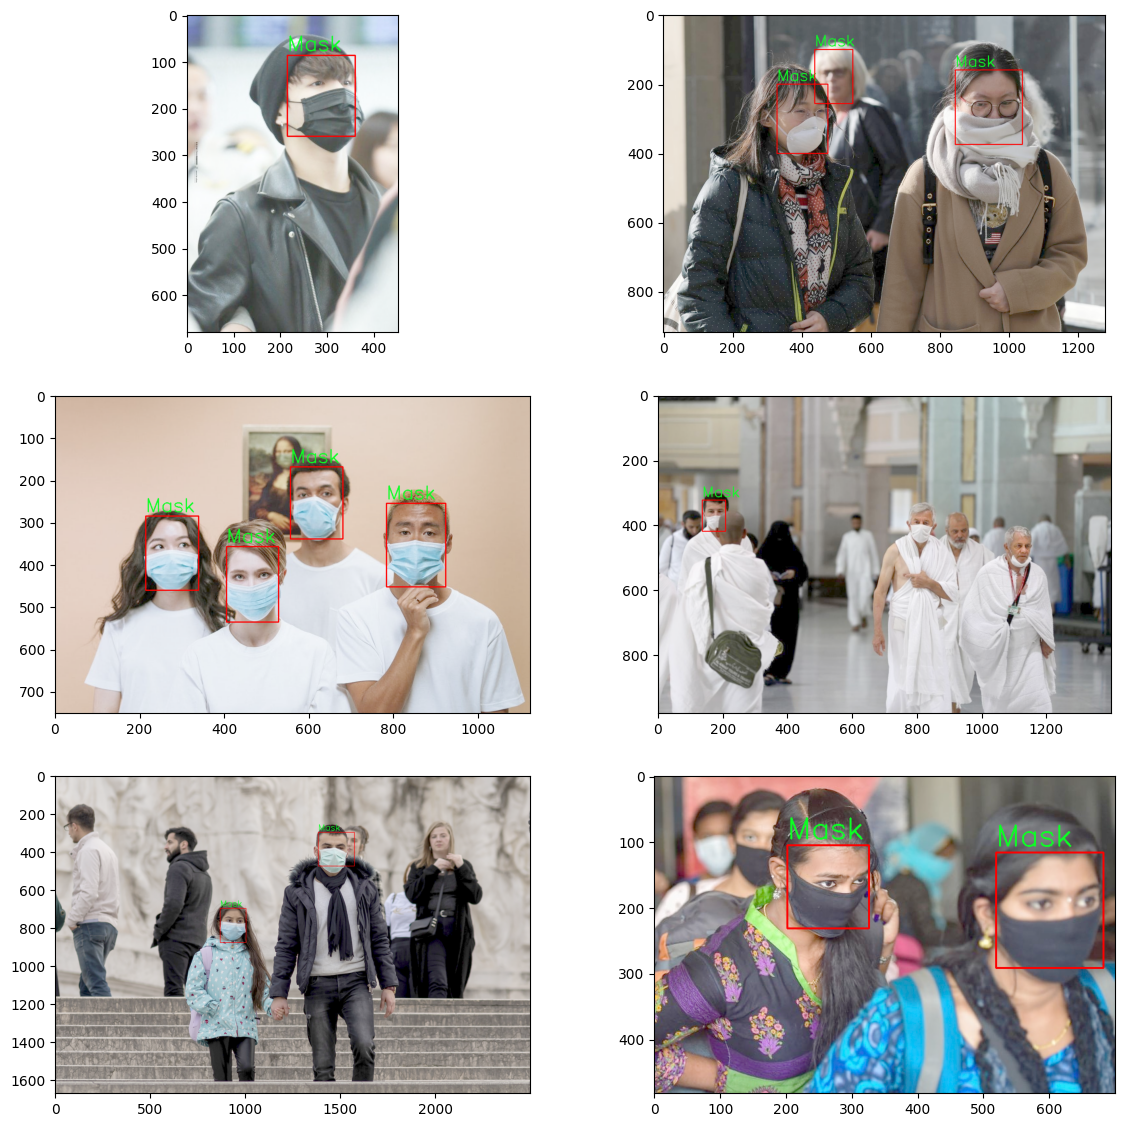

In [13]:
test_images = ['1115.jpg','1504.jpg', '0072.jpg','0012.jpg','0353.jpg','1374.jpg']

gamma = 2.0
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
assign = {'0':'Mask','1':"No Mask"}
for j,im in enumerate(test_images):
    image =  cv2.imread(os.path.join(image_directory,im),1)
    image =  adjust_gamma(image, gamma=gamma)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            if confidence > 0.2:
                im = cv2.resize(frame,(img_size,img_size))
                im = np.array(im)/255.0
                im = im.reshape(1,124,124,3)
                result = model.predict(im)
                if result>0.5:
                    label_Y = 1
                else:
                    label_Y = 0
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36,255,12), 2)
        
        except:pass
    axes.append(fig.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()